100%|██████████| 169001437/169001437 [00:08<00:00, 20974066.28it/s]


Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 217MB/s]


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training Loss: 2.6568, Training Accuracy: 0.3253
Validation Loss: 1.9084, Validation Accuracy: 0.5042
Validation Accuracy improved to 0.5042. Model saved.
Epoch 2/50
Training Loss: 1.8148, Training Accuracy: 0.5094
Validation Loss: 1.4320, Validation Accuracy: 0.6035
Validation Accuracy improved to 0.6035. Model saved.
Epoch 3/50
Training Loss: 1.6191, Training Accuracy: 0.5601
Validation Loss: 1.2980, Validation Accuracy: 0.6332
Validation Accuracy improved to 0.6332. Model saved.
Epoch 4/50
Training Loss: 1.4734, Training Accuracy: 0.5967
Validation Loss: 1.1481, Validation Accuracy: 0.6757
Validation Accuracy improved to 0.6757. Model saved.
Epoch 5/50
Training Loss: 1.3794, Training Accuracy: 0.6208
Validation Loss: 1.1836, Validation Accuracy: 0.6774
Validation Accuracy improved to 0.6774. Model saved.
Epoch 6/50
Training Loss: 1.2951, Training Accuracy: 0.6434
Validation Loss: 1.1921, Validation Accuracy: 0.6773
No improvement in Validation Accuracy. Patience counter: 1/7
Epoch 7

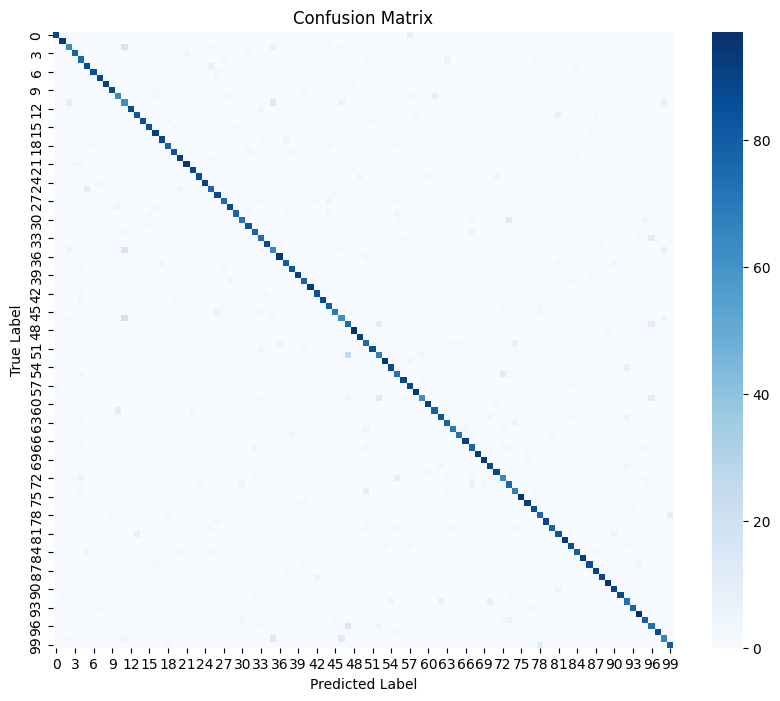

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       100
           1       0.95      0.94      0.94       100
           2       0.72      0.63      0.67       100
           3       0.79      0.78      0.78       100
           4       0.63      0.76      0.69       100
           5       0.81      0.87      0.84       100
           6       0.89      0.86      0.87       100
           7       0.87      0.88      0.88       100
           8       0.95      0.92      0.93       100
           9       0.89      0.88      0.88       100
          10       0.67      0.64      0.66       100
          11       0.47      0.62      0.53       100
          12       0.92      0.88      0.90       100
          13       0.80      0.82      0.81       100
          14       0.91      0.86      0.88       100
          15       0.86      0.85      0.85       100
          16       0.81      0.91      0.86       100
    

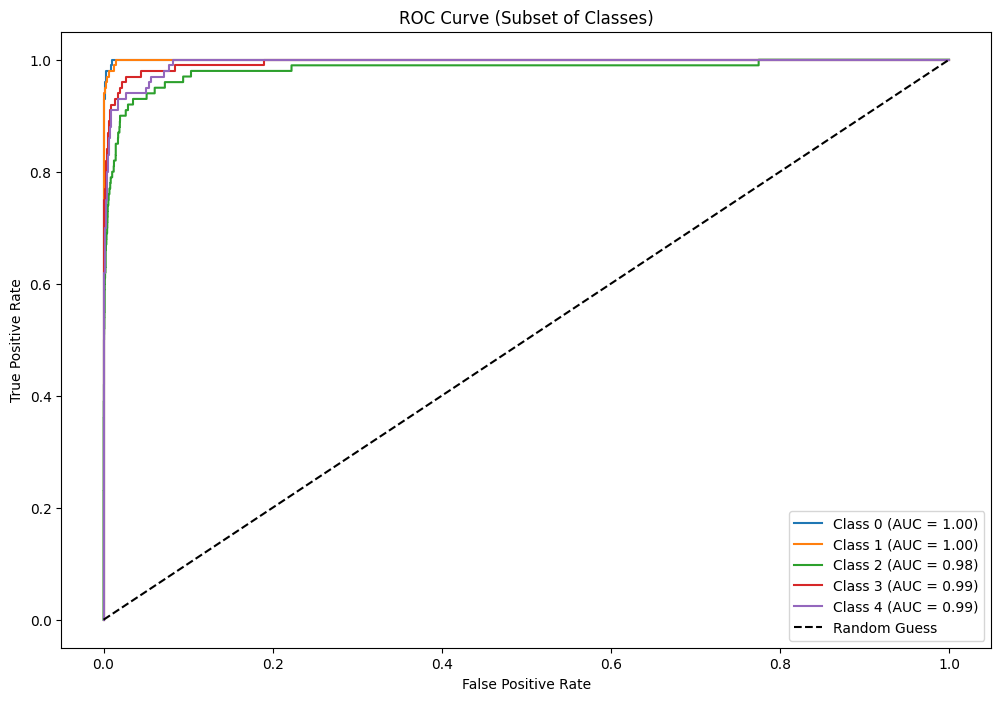

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data transformations with enhanced augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.RandomGrayscale(p=0.1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load CIFAR-100 dataset
train_dataset = datasets.CIFAR100(root='data', train=True, download=True, transform=train_transform)
val_dataset = datasets.CIFAR100(root='data', train=False, download=True, transform=val_transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

# Define the model using ResNet50
base_model = models.resnet50(pretrained=True)
num_features = base_model.fc.in_features
base_model.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 100)
)

# Move model to the device
model = base_model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

# Training function with early stopping
def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=7):
    best_acc = 0.0
    patience_counter = 0
    best_model_state = None

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        print(f"Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)
        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_running_corrects.double() / len(val_loader.dataset)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

        # Learning rate scheduler step
        scheduler.step(val_acc)

        # Check for improvement in validation accuracy
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_state = model.state_dict()
            patience_counter = 0
            print(f"Validation Accuracy improved to {val_acc:.4f}. Model saved.")
        else:
            patience_counter += 1
            print(f"No improvement in Validation Accuracy. Patience counter: {patience_counter}/{patience}")

        # Check if patience has been exhausted
        if patience_counter >= patience:
            print(f"Early stopping triggered. Best Validation Accuracy: {best_acc:.4f}")
            break

    # Load the best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model

# Train the model with early stopping
model = train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=7)

# Save the best model
torch.save(model.state_dict(), 'resnet50_cifar100_best_tweaked.pth')

# Evaluate the model and generate performance metrics
def evaluate_model_with_metrics(model, val_loader, num_classes=100, n_classes_to_plot=5):
    y_true = []
    y_pred = []
    y_prob = []

    # Collect predictions and true labels
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=True)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(num_classes)]))

    # ROC Curve for selected classes
    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
    plt.figure(figsize=(12, 8))
    for i in range(min(n_classes_to_plot, num_classes)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Subset of Classes)")
    plt.legend(loc="lower right")
    plt.show()

# Evaluate the model
model.eval()
evaluate_model_with_metrics(model, val_loader)